### This tutorial demonstrates the binary analysis workflow of `BreathPy`.
Initially sample data (MCC-IMS measurements of breath after consuming either `menthol` or `citrus` candy, see material section of https://www.mdpi.com/2218-1989/10/10/393 for more information) is downloaded and split into a training and test fraction - the test samples will later serve to validate the created random forest classifier. The samples are normalized and denoised. Afterwards, several peak-detection methods are applied including the `VisualnowLayer` contained in the sample data. Subsequently peaks are aligned using the `ProbeClustering` approach and the features are reduced using `RemovePercentageFeatures` - which limits the reported features to the ones present in at least `percentage_threshold` of the minority class - in this case `citrus`. 
Features are then weighted using the `PerformanceMeasure`s `RANDOM_FOREST_CLASSIFICATION` and `FDR_CORRECTED_P_VALUE` - leaving 10 features each. 
Two decision trees and a `RandomForestClassifier` are trained. They serve as visual interpretation of the classifcation strategy based on each `PerformanceMeasure`.
After training, the `RandomForestClassifier` is used to predict the class labels of the test samples.
Finally, plots are created and saved in the `results/plots/` directory.

In [18]:
# handle imports
from urllib.request import urlretrieve
from shutil import move as file_move
import numpy as np
import pandas as pd
from pathlib import Path
from zipfile import ZipFile
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

from breathpy.generate_sample_data import generate_train_test_sets, generate_train_test_set_helper
from breathpy.model.BreathCore import (MccImsAnalysis, MccImsMeasurement, PredictionModel,
                              construct_default_parameters,
                              construct_default_processing_evaluation_steps,
                              construct_custom_processing_evaluation_dict)
from breathpy.model.ProcessingMethods import FeatureReductionMethod, PerformanceMeasure, GCMSPeakDetectionMethod, GCMSAlignmentMethod
from breathpy.tools.tools import get_peax_binary_path

from breathpy.view.BreathVisualizations import ClusterPlot, HeatmapPlot, RocCurvePlot, BoxPlot, TreePlot, TimeSeriesPlot

In [19]:
# download sample data and split into train and test fraction

url = 'https://github.com/philmaweb/BreathAnalysis.github.io/raw/master/data/full_candy.zip'
zip_dst = Path("data/full_candy.zip")
dst_dir = Path("data/full_candy/")
dst_dir.mkdir(parents=True, exist_ok=True)
urlretrieve(url, zip_dst)

# unzip archive into data subdirectory
with ZipFile(zip_dst, "r") as archive_handle:
    archive_handle.extractall(Path(dst_dir))

raw_dir = dst_dir
target_dir = Path("data/")

# split into train and test fraction - use 1/3 of samples for validation
generate_train_test_sets(dir_full_set=raw_dir, root_target_dir=target_dir, cross_val_num=3, seed=42)

Missing raw files: []
Preparing dataset for Counter({'menthol': 22, 'citrus': 20}) using 3-fold cross validation splits.
Deleting data/train_full_candy/ and data/test_full_candy/
Creating data/train_full_candy/ and data/test_full_candy/
||||||||||||||||||||||||||||||||||||||||
Finished preparation of full_candy



(                       name    label
 0   BD18_1408280834_ims.csv   citrus
 1   BD18_1408280838_ims.csv   citrus
 2   BD18_1408280844_ims.csv  menthol
 3   BD18_1408280851_ims.csv   citrus
 4   BD18_1511121654_ims.csv  menthol
 5   BD18_1511121658_ims.csv   citrus
 6   BD18_1511121706_ims.csv  menthol
 7   BD18_1511121709_ims.csv   citrus
 8   BD18_1511121719_ims.csv  menthol
 9   BD18_1511121723_ims.csv  menthol
 10  BD18_1511121730_ims.csv  menthol
 11  BD18_1511121734_ims.csv  menthol
 12  BD18_1511121738_ims.csv  menthol
 13  BD18_1511121742_ims.csv   citrus
 14  BD18_1711291646_ims.csv   citrus
 15  BD18_1711291656_ims.csv   citrus
 16  BD18_1711291709_ims.csv  menthol
 17  BD18_1711291712_ims.csv   citrus
 18  BD18_1711291715_ims.csv  menthol
 19  BD18_1711291722_ims.csv   citrus
 20  BD18_1711291725_ims.csv  menthol
 21  BD18_1711291729_ims.csv   citrus
 22  BD18_1711291732_ims.csv  menthol
 23  BD18_1711291736_ims.csv   citrus
 24  BD18_1711291739_ims.csv   citrus
 25  BD18_17

### Now we simplify and go step-by-step through the methods called by `breathpy.model.CoreTest.run_start_to_end_pipeline`

In [3]:
# define default parameters and train / test directory
folder_name = file_prefix = 'train_full_candy'
plot_parameters, file_parameters = construct_default_parameters(file_prefix, folder_name, make_plots=True)

# create default parameters for preprocessing and evaluation
preprocessing_steps, evaluation_params_dict = construct_default_processing_evaluation_steps()

# define directory for training and test set
train_dir = Path("data/train_full_candy/")
test_dir = Path("data/test_full_candy/")

# get class label dict file from training set
train_class_label_dict_fn = MccImsAnalysis.guess_class_label_extension(train_dir)

# read in raw mcc-ims measurements of training set - based on class_label_dict
train_measurements = [MccImsMeasurement(fn) for fn in train_dir.glob("*ims.csv")]

Parsing Measurement data/train_full_candy/BD18_1511121723_ims.csv
Parsing Measurement data/train_full_candy/BD18_1711291736_ims.csv
Parsing Measurement data/train_full_candy/BD18_1711291712_ims.csv
Parsing Measurement data/train_full_candy/BD18_1711291656_ims.csv
Parsing Measurement data/train_full_candy/BD18_1711291739_ims.csv
Parsing Measurement data/train_full_candy/BD18_1408280844_ims.csv
Parsing Measurement data/train_full_candy/BD18_1711291709_ims.csv
Parsing Measurement data/train_full_candy/BD18_1408280834_ims.csv
Parsing Measurement data/train_full_candy/BD18_1511121654_ims.csv
Parsing Measurement data/train_full_candy/BD18_1511121706_ims.csv
Parsing Measurement data/train_full_candy/BD18_1711291729_ims.csv
Parsing Measurement data/train_full_candy/BD18_1711291732_ims.csv
Parsing Measurement data/train_full_candy/BD18_1408280851_ims.csv
Parsing Measurement data/train_full_candy/BD18_1511121730_ims.csv
Parsing Measurement data/train_full_candy/BD18_1511121742_ims.csv
Parsing Me

In [6]:
# setup analysis - need to get path of peax binary and get the visualnowlayer filename
visualnow_layer_path = Path("data/train_full_candy/candy_layer.xls")

# create output directory
if not Path(file_parameters['out_dir']).exists():
    Path(file_parameters['out_dir']).mkdir(parents=True, exist_ok=True)

# create analysis
ims_analysis = MccImsAnalysis(
    train_measurements, preprocessing_steps, performance_measure_parameters=evaluation_params_dict,
    class_label_file=train_class_label_dict_fn, dataset_name=folder_name, visualnow_layer_file=visualnow_layer_path,
    peax_binary_path=get_peax_binary_path())

# run normalization, denoising and peak_detection for measurements using 6 cores
# for peak_detection we run [PEAX, WATERSHED, VISUALNOWLAYER, TOPHAT] methods defined in preprocessing_steps
# if one want to change default parameters, pass updated parameters for preprocessing_parameters
ims_analysis.preprocess_multicore(num_cores=6)

Applying External Preprocessing with ExternalPeakDetectionMethod.PEAX
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTIONApplying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY

Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION

Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATIONApplying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITYApplying Normalization NormalizationMethod.BASELINE_CORRECTION


Applying Normalization NormalizationMethod.IN

Applying Normalization NormalizationMethod.BASELINE_CORRECTIONApplying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION

Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATIONApplying Normalization NormalizationMethod.BASELINE_CORRECTION

Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTE

/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy-0.9.1-py3.8.egg/breathpy/view/BreathVisualizations.py:43: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = skcolor.rgb2gray(df.T.values)
/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy-0.9.1-py3.8.egg/breathpy/view/BreathVisualizations.py:532: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_tick_labels))
/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy-0.9.1-py3.8.egg/breathpy/view/BreathVisualizations.py:533: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_tick_labels))


Saving figure to results/plots/heatmapsfast_train_full_candy_intentsity_plot_BD18_1408280834_ims.png


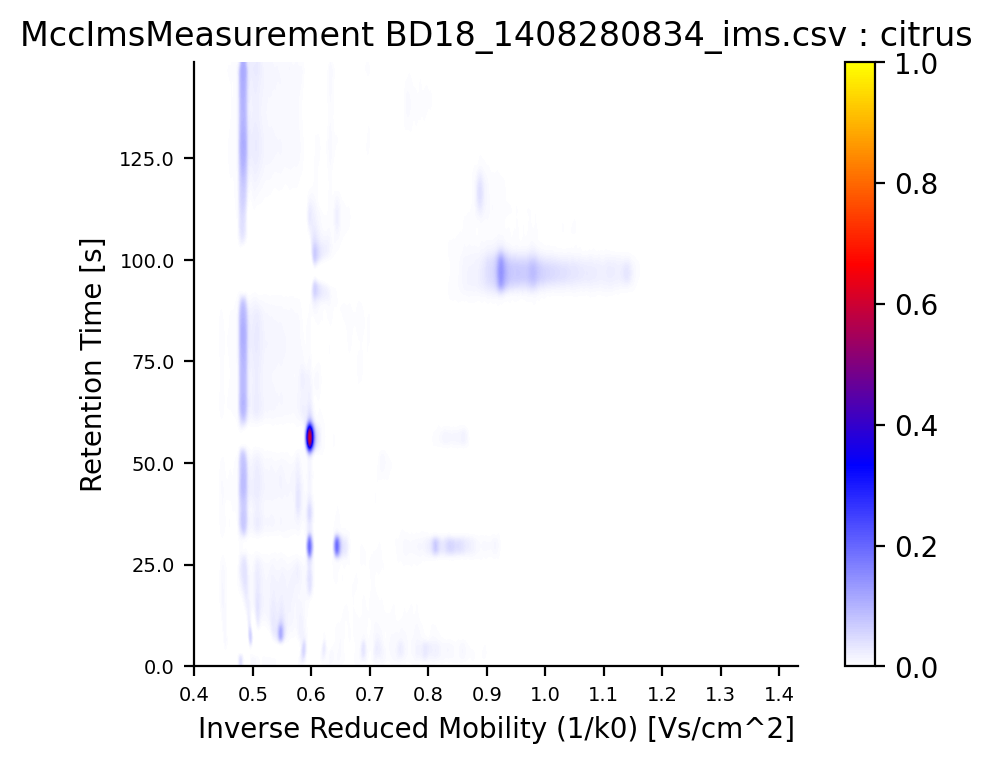

In [7]:
# plot and show a preprocessed measurement
test_measurement = ims_analysis.measurements[0]
HeatmapPlot.FastIntensityMatrix(test_measurement, plot_parameters=plot_parameters, title=str(test_measurement))

Image(Path("results/plots/heatmaps/fast_train_full_candy_intentsity_plot_BD18_1408280834_ims.png"))

In [8]:
# align peak detection results
ims_analysis.align_peaks()

Applying Peak Alignment PeakAlignmentMethod.PROBE_CLUSTERING
Handling FloatPeakAlignmentResult for _align_peaks_probe_clustering
Applying Probe clustering to dict_keys(['PEAX', 'WATERSHED', 'VISUALNOWLAYER', 'TOPHAT'])


#### Visualize
* show average chromatogram for each candy type - after normalization and denoising
* show clusters for each peak detection method

Plotting Classwise Overlay Plots
class_str=by_class-citrus
class_label=citrus


/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy-0.9.1-py3.8.egg/breathpy/view/BreathVisualizations.py:43: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = skcolor.rgb2gray(df.T.values)
/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy-0.9.1-py3.8.egg/breathpy/view/BreathVisualizations.py:532: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_tick_labels))
/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy-0.9.1-py3.8.egg/breathpy/view/BreathVisualizations.py:533: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_tick_labels))


class_str=by_class-menthol
class_label=menthol


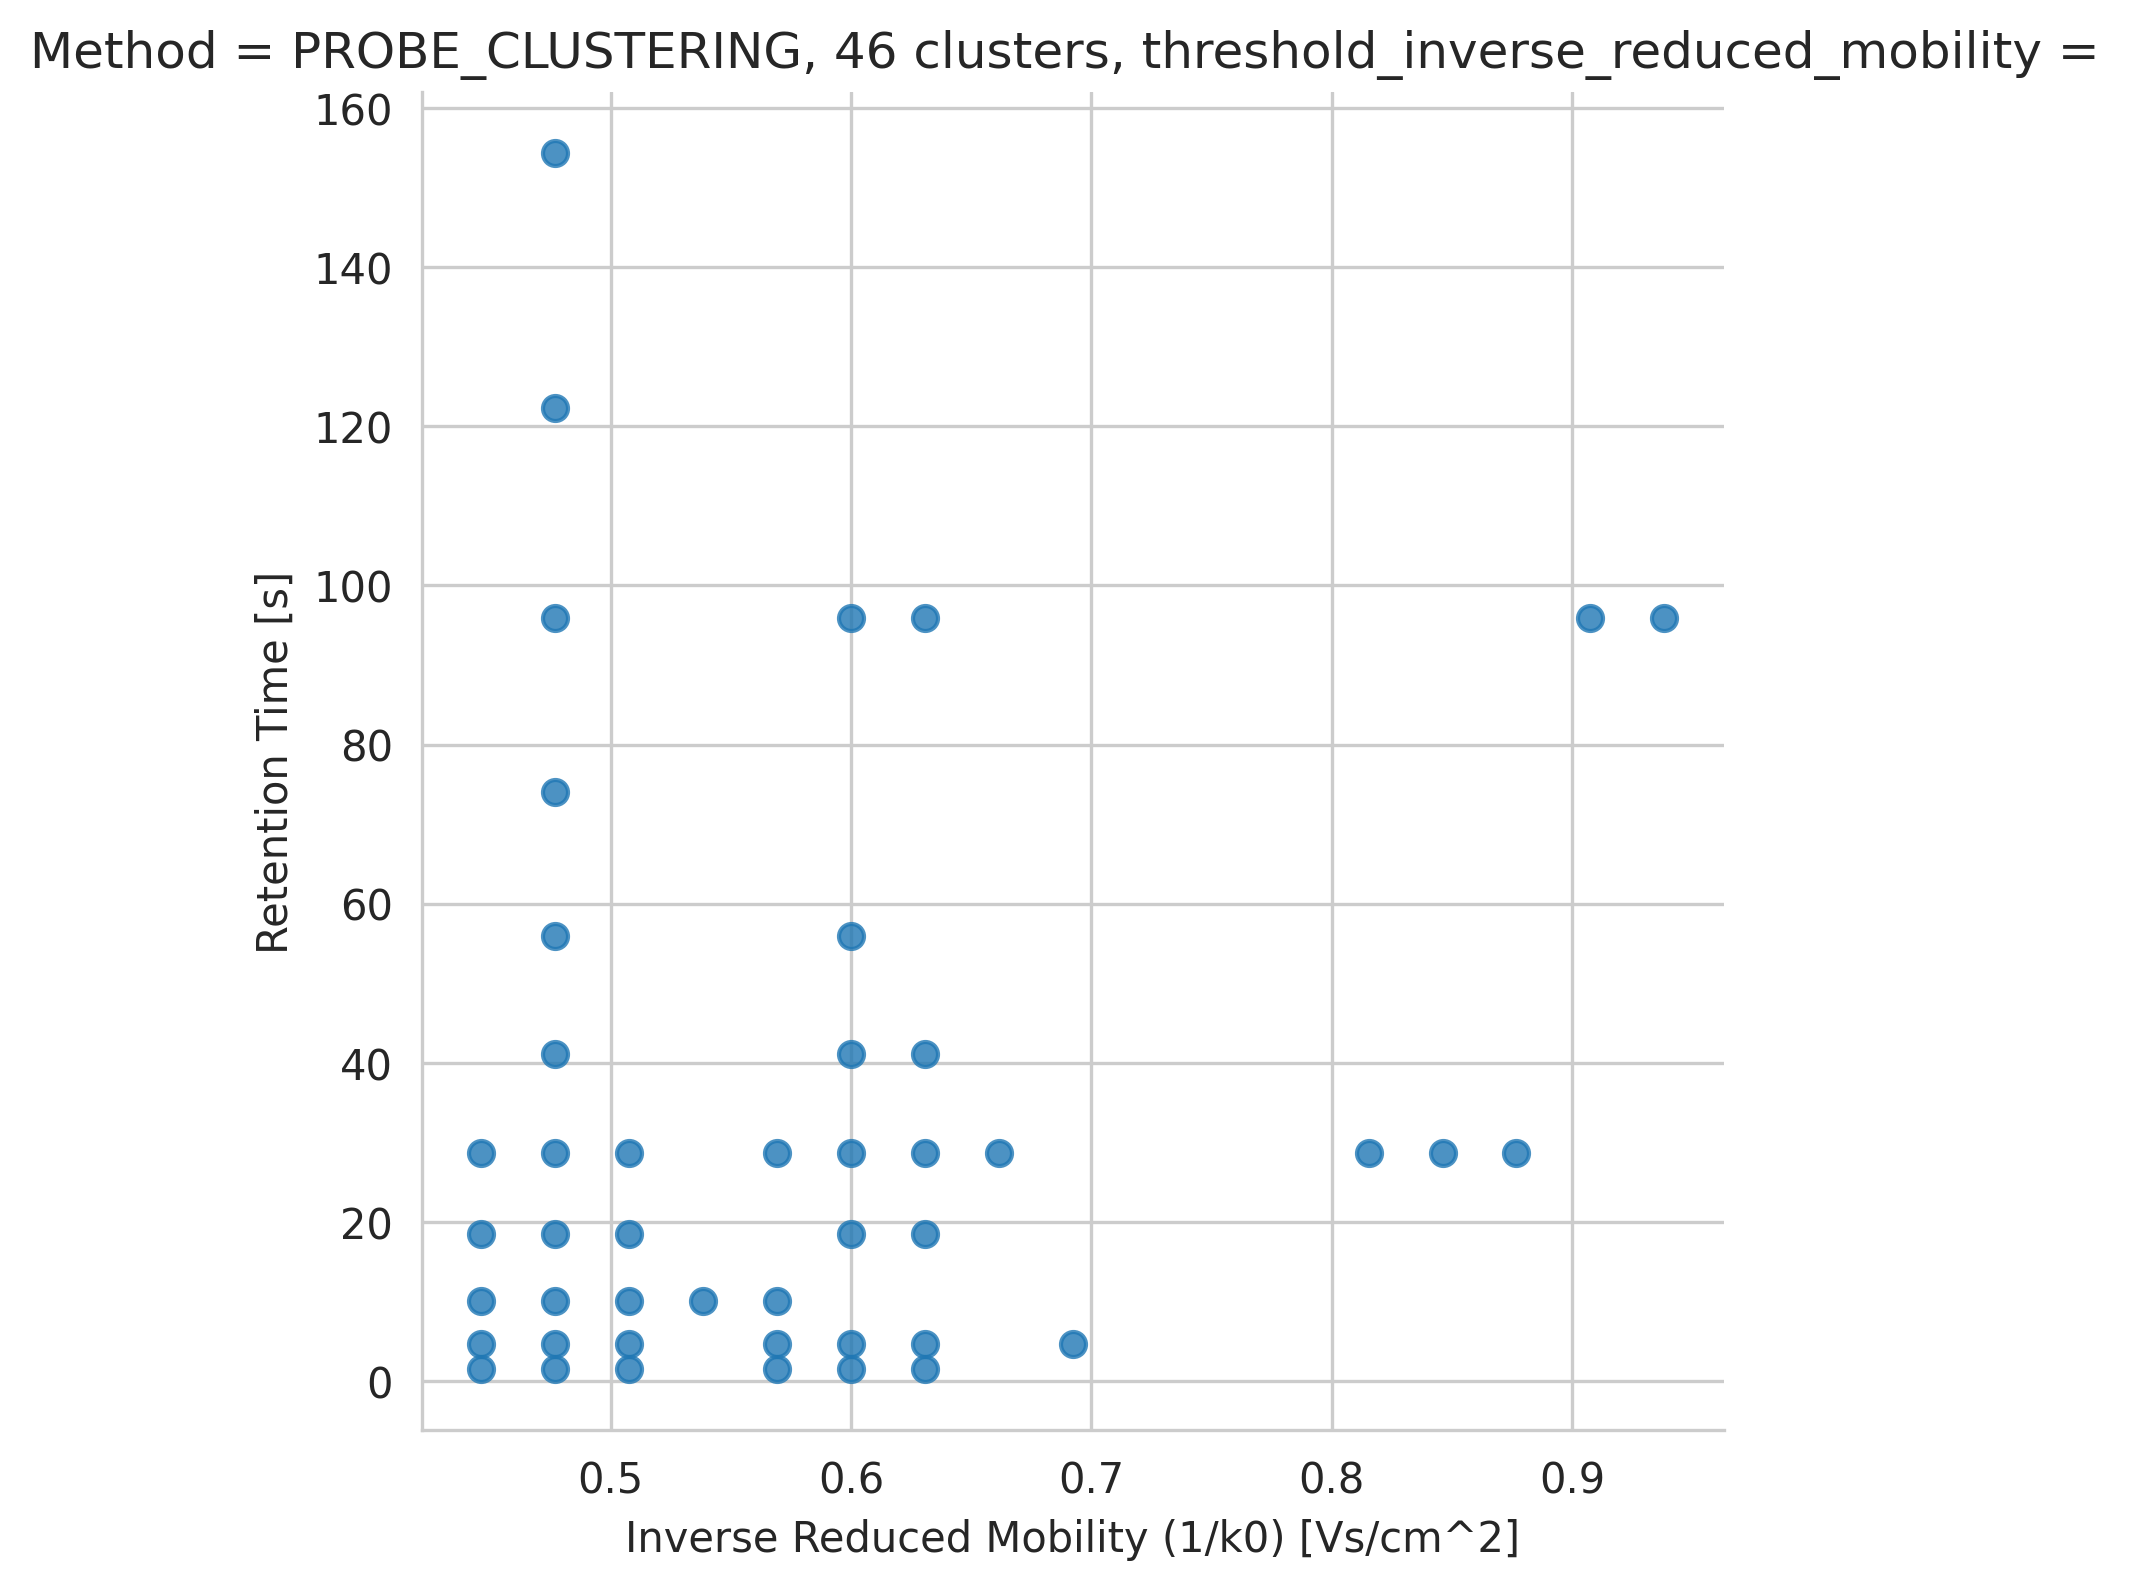

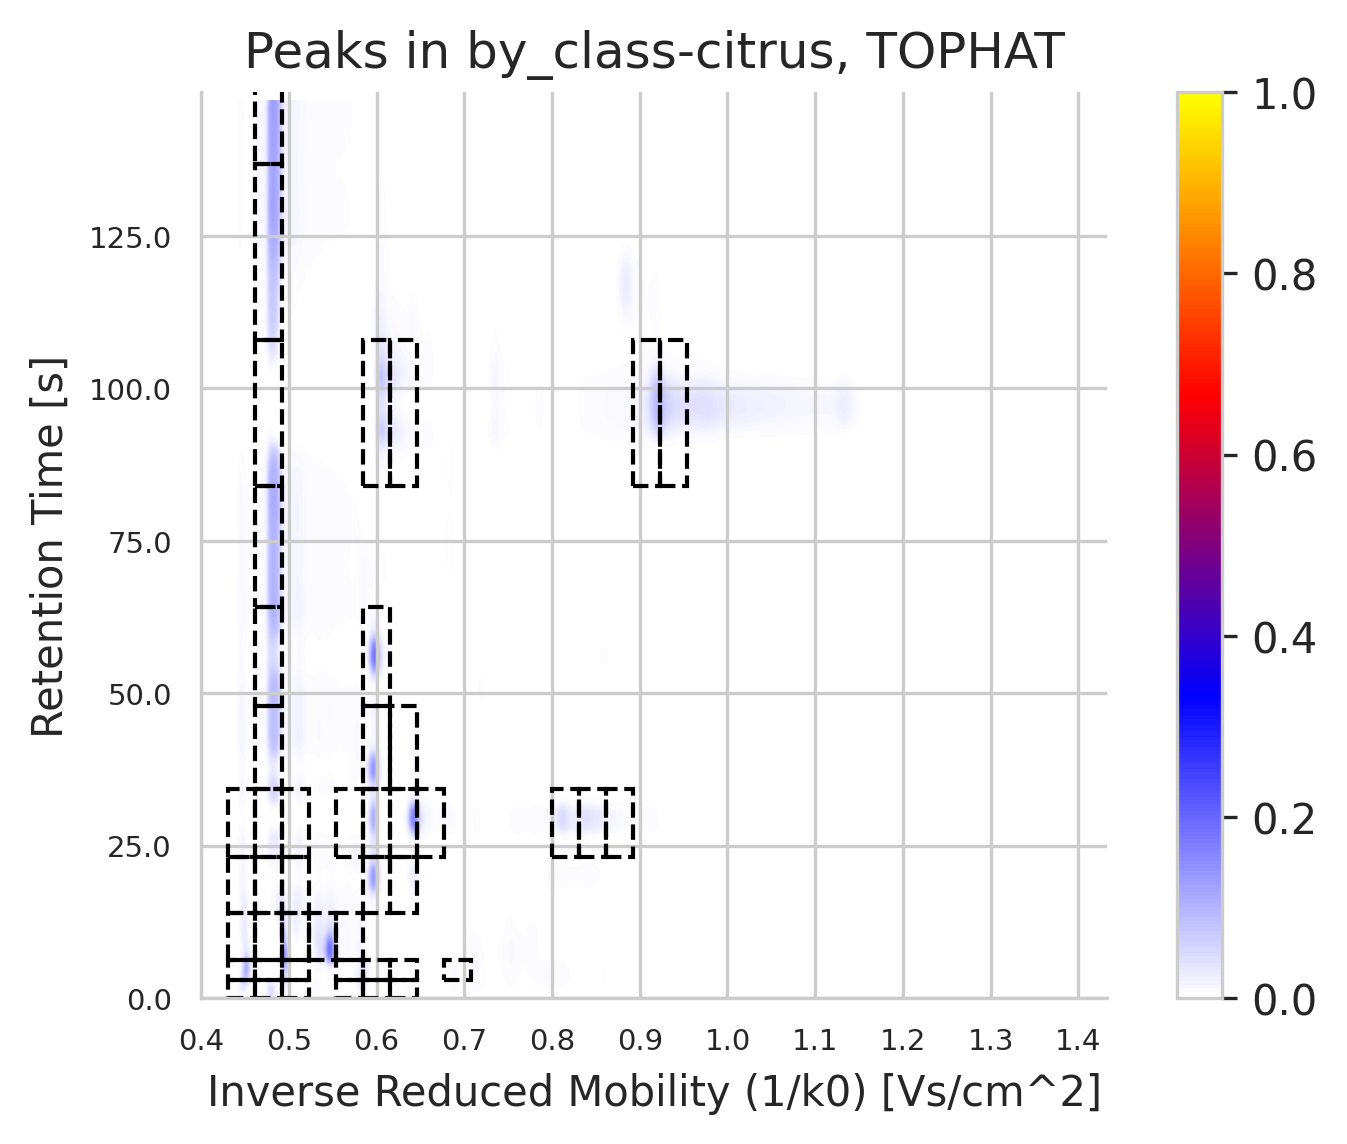

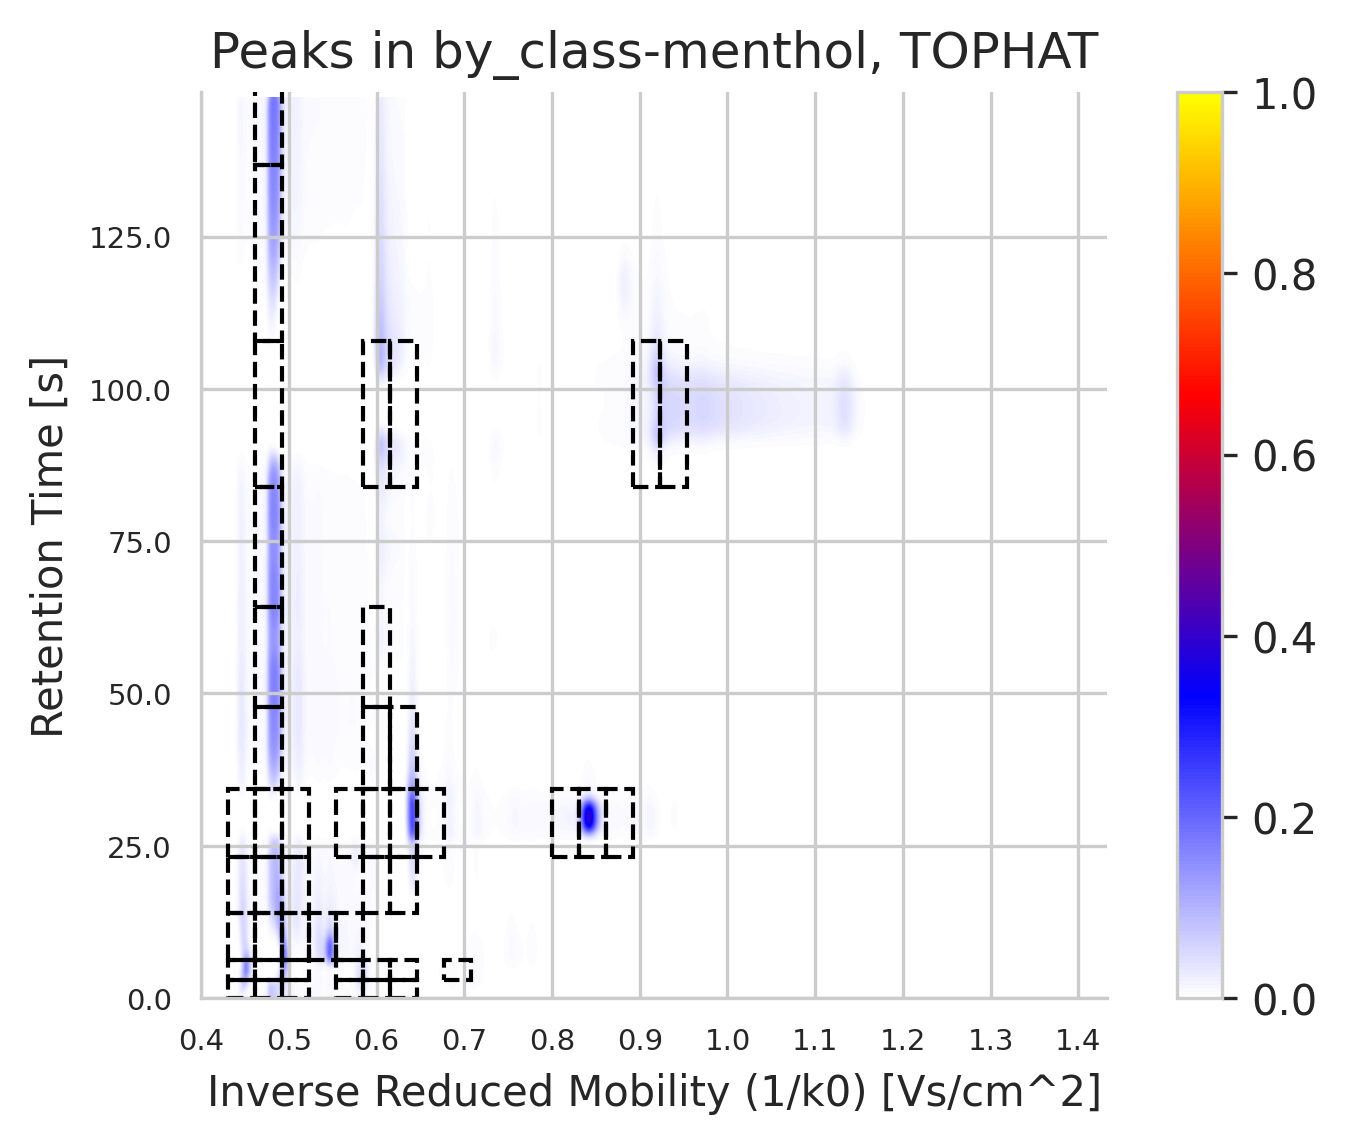

In [9]:
clusters = ClusterPlot.ClusterBasic(ims_analysis, plot_parameters=plot_parameters)
overlays = ClusterPlot.OverlayClasswiseAlignment(ims_analysis, plot_parameters=plot_parameters)

# get paths of the images
cluster_fn = Path(clusters[2][-1])
overlay_fn_citrus =Path("results/plots/overlay/")/overlays[2][-1]
overlay_fn_menthol =Path("results/plots/overlay/")/overlays[-2][-1]

# display images for the TOPHAT method
images = [cluster_fn, overlay_fn_citrus, overlay_fn_menthol]

for fn in images:
    display(Image(fn))

In [10]:
# apply feature reduction
ims_analysis.reduce_features(ims_analysis.AVAILABLE_FEATURE_REDUCTION_METHODS)
# evaluate model performance using 3-fold cross-validation
ims_analysis.evaluate_performance()

Applying feature reduction with {RANDOM_FOREST_CLASSIFICATION: {'n_splits_cross_validation': 3, 'n_estimators_random_forest': 2000, 'n_of_features': 10}, FDR_CORRECTED_P_VALUE: {'benjamini_hochberg_alpha': 0.05, 'n_of_features': 10}, DECISION_TREE_TRAINING: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}, REMOVE_PERCENTAGE_FEATURES: {'noise_threshold': 0.0001, 'percentage_threshold': 0.5}}
Reduced WATERSHED AlignmentResult from 1758 to 86 features by applying noise_threshold 0.0001 and percentage_threshold 0.5
Reduced VISUALNOWLAYER AlignmentResult from 392 to 14 features by applying noise_threshold 0.0001 and percentage_threshold 0.5
Reduced TOPHAT AlignmentResult from 449 to 20 features by applying noise_threshold 0.0001 and percentage_threshold 0.5
Reduced PEAX AlignmentResult from 1084 to 48 features by applying noise_threshold 0.0001 and percentage_threshold 0.5
Applying performance measure PerformanceMeasure.RANDOM_FOREST_CLASSIFICATION with {'n_splits_cross_valid

In [11]:
# export preprocessed files, peak detection results and feature_matrixes to csv into results directory
print(file_parameters['out_dir'])

# export preprocessed files, peak detection results and feature_matrixes to csv into results directory
ims_analysis.export_results_to_csv(file_parameters['out_dir'])

results/data/train_full_candy/
Saving preprocessed measurement to results/data/train_full_candy/BD18_1408280834_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_full_candy/BD18_1408280838_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_full_candy/BD18_1408280844_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_full_candy/BD18_1408280851_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_full_candy/BD18_1511121654_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_full_candy/BD18_1511121658_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_full_candy/BD18_1511121706_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_full_candy/BD18_1511121709_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_full_candy/BD18_1511121719_ims_preprocessed.csv
Saving preprocessed measurement to results/data/tra

#### Visualize the analysis:
* show estimated model performance - ROC curve
* show best features superimposed for each candy type
* plot boxplot and time-series plot for each feature


Plotting binary ROC curve
Plotting Boxplots of the best features SEABORN
Plotting Decision trees buffer = False for AnalysisResult of dataset 'train_full_candy' with [WATERSHED, VISUALNOWLAYER, TOPHAT, PEAX] PeakAlignmentMethod.PROBE_CLUSTERING for 28 measurements
Saving figure to results/plots/time_series/train_full_candy_TOPHAT_Peak_0231_time_series.png
Saving figure to results/plots/time_series/train_full_candy_TOPHAT_Peak_0178_time_series.png
Saving figure to results/plots/time_series/train_full_candy_TOPHAT_Peak_0178_time_series.png
Saving figure to results/plots/time_series/train_full_candy_TOPHAT_Peak_0231_time_series.png


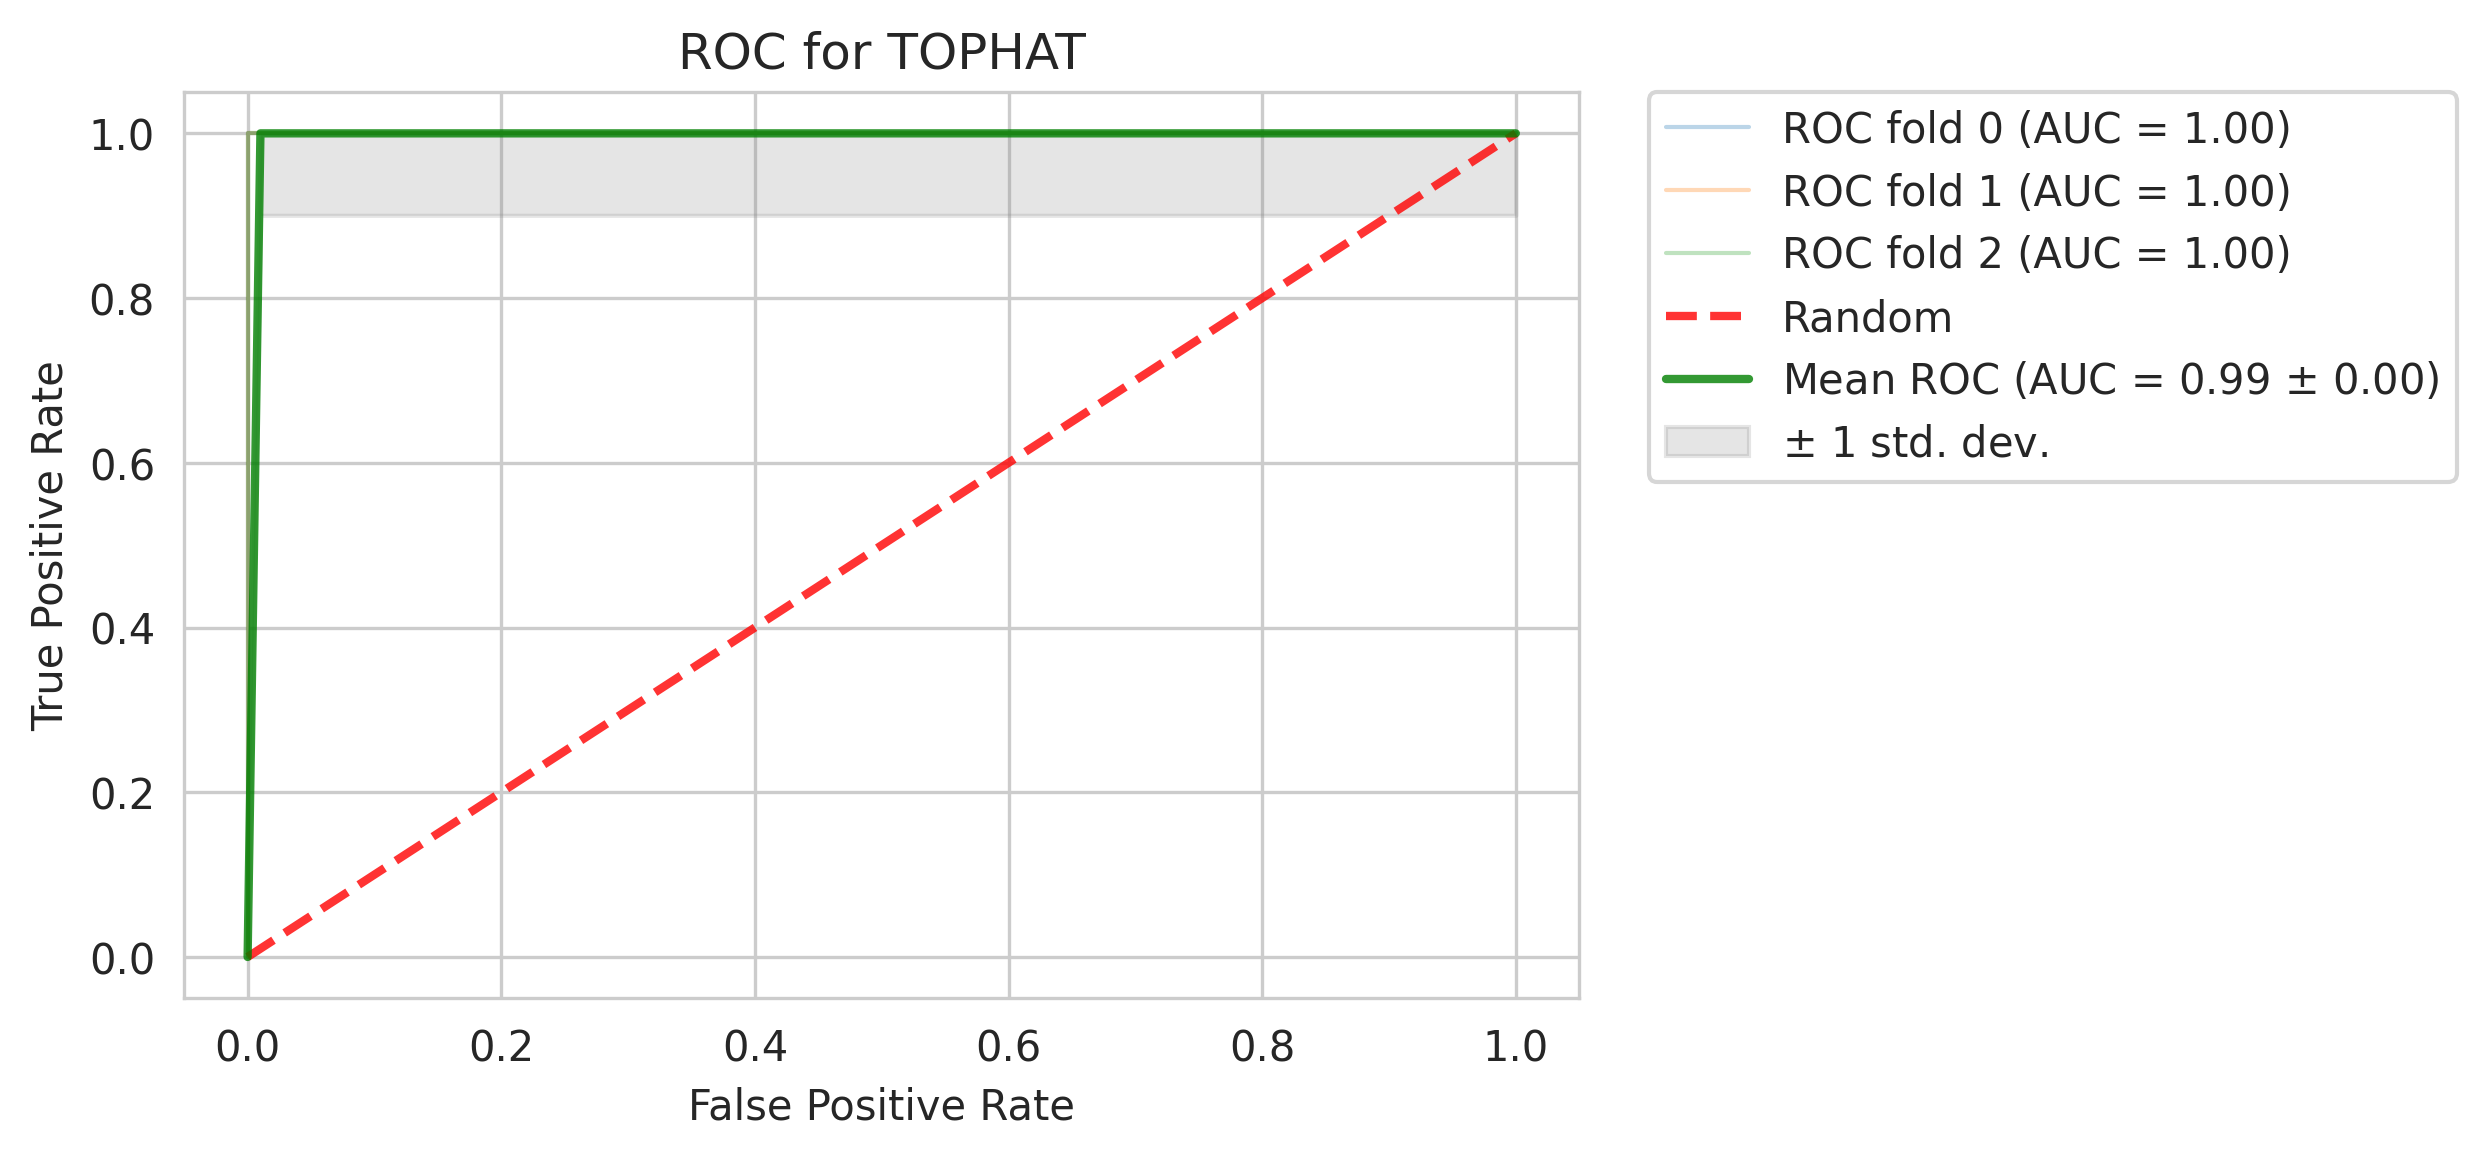

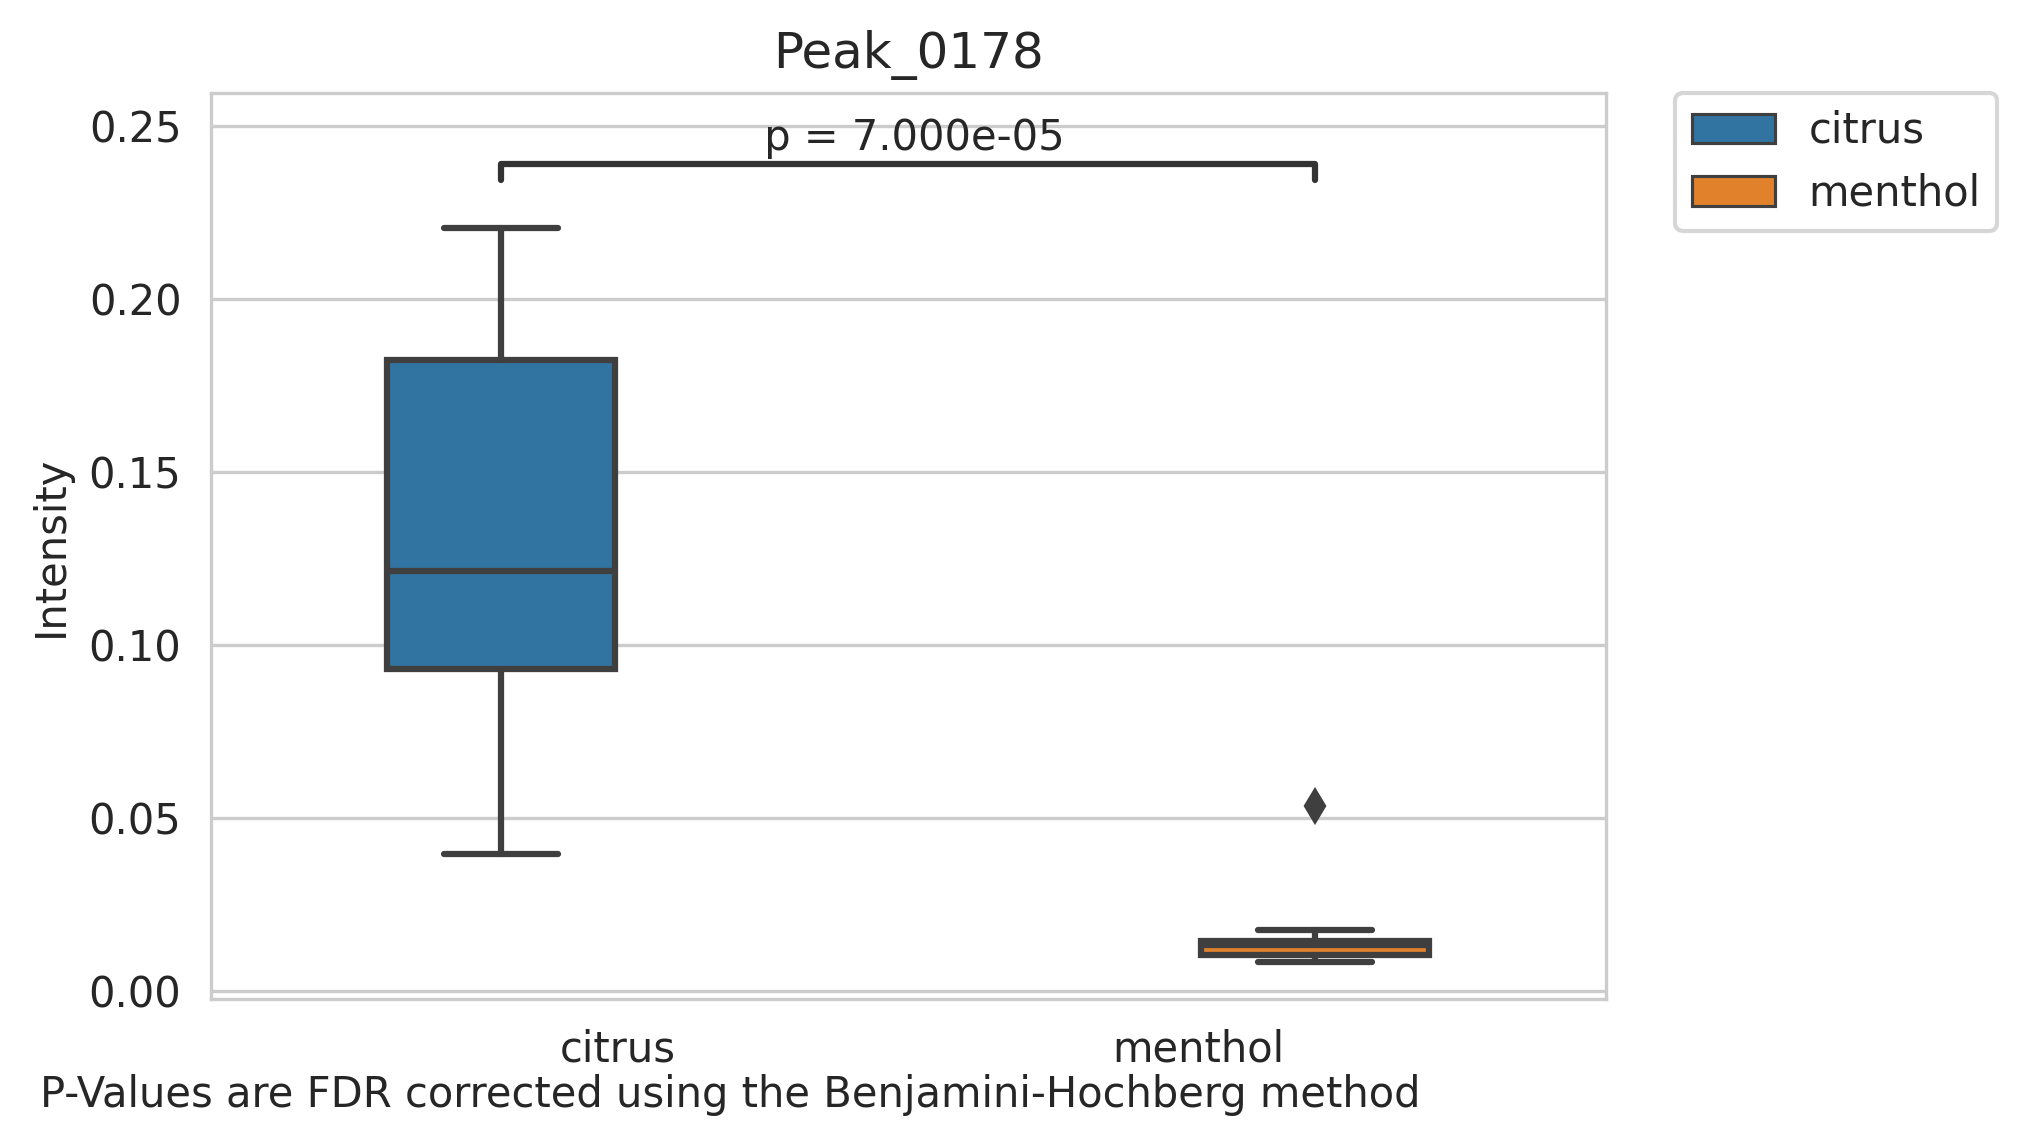

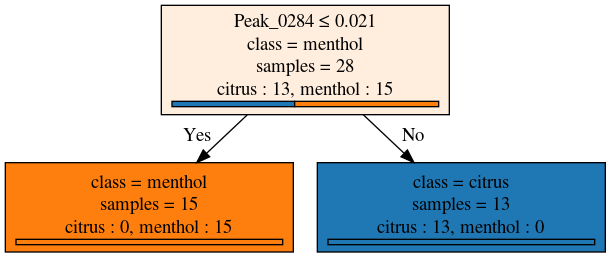

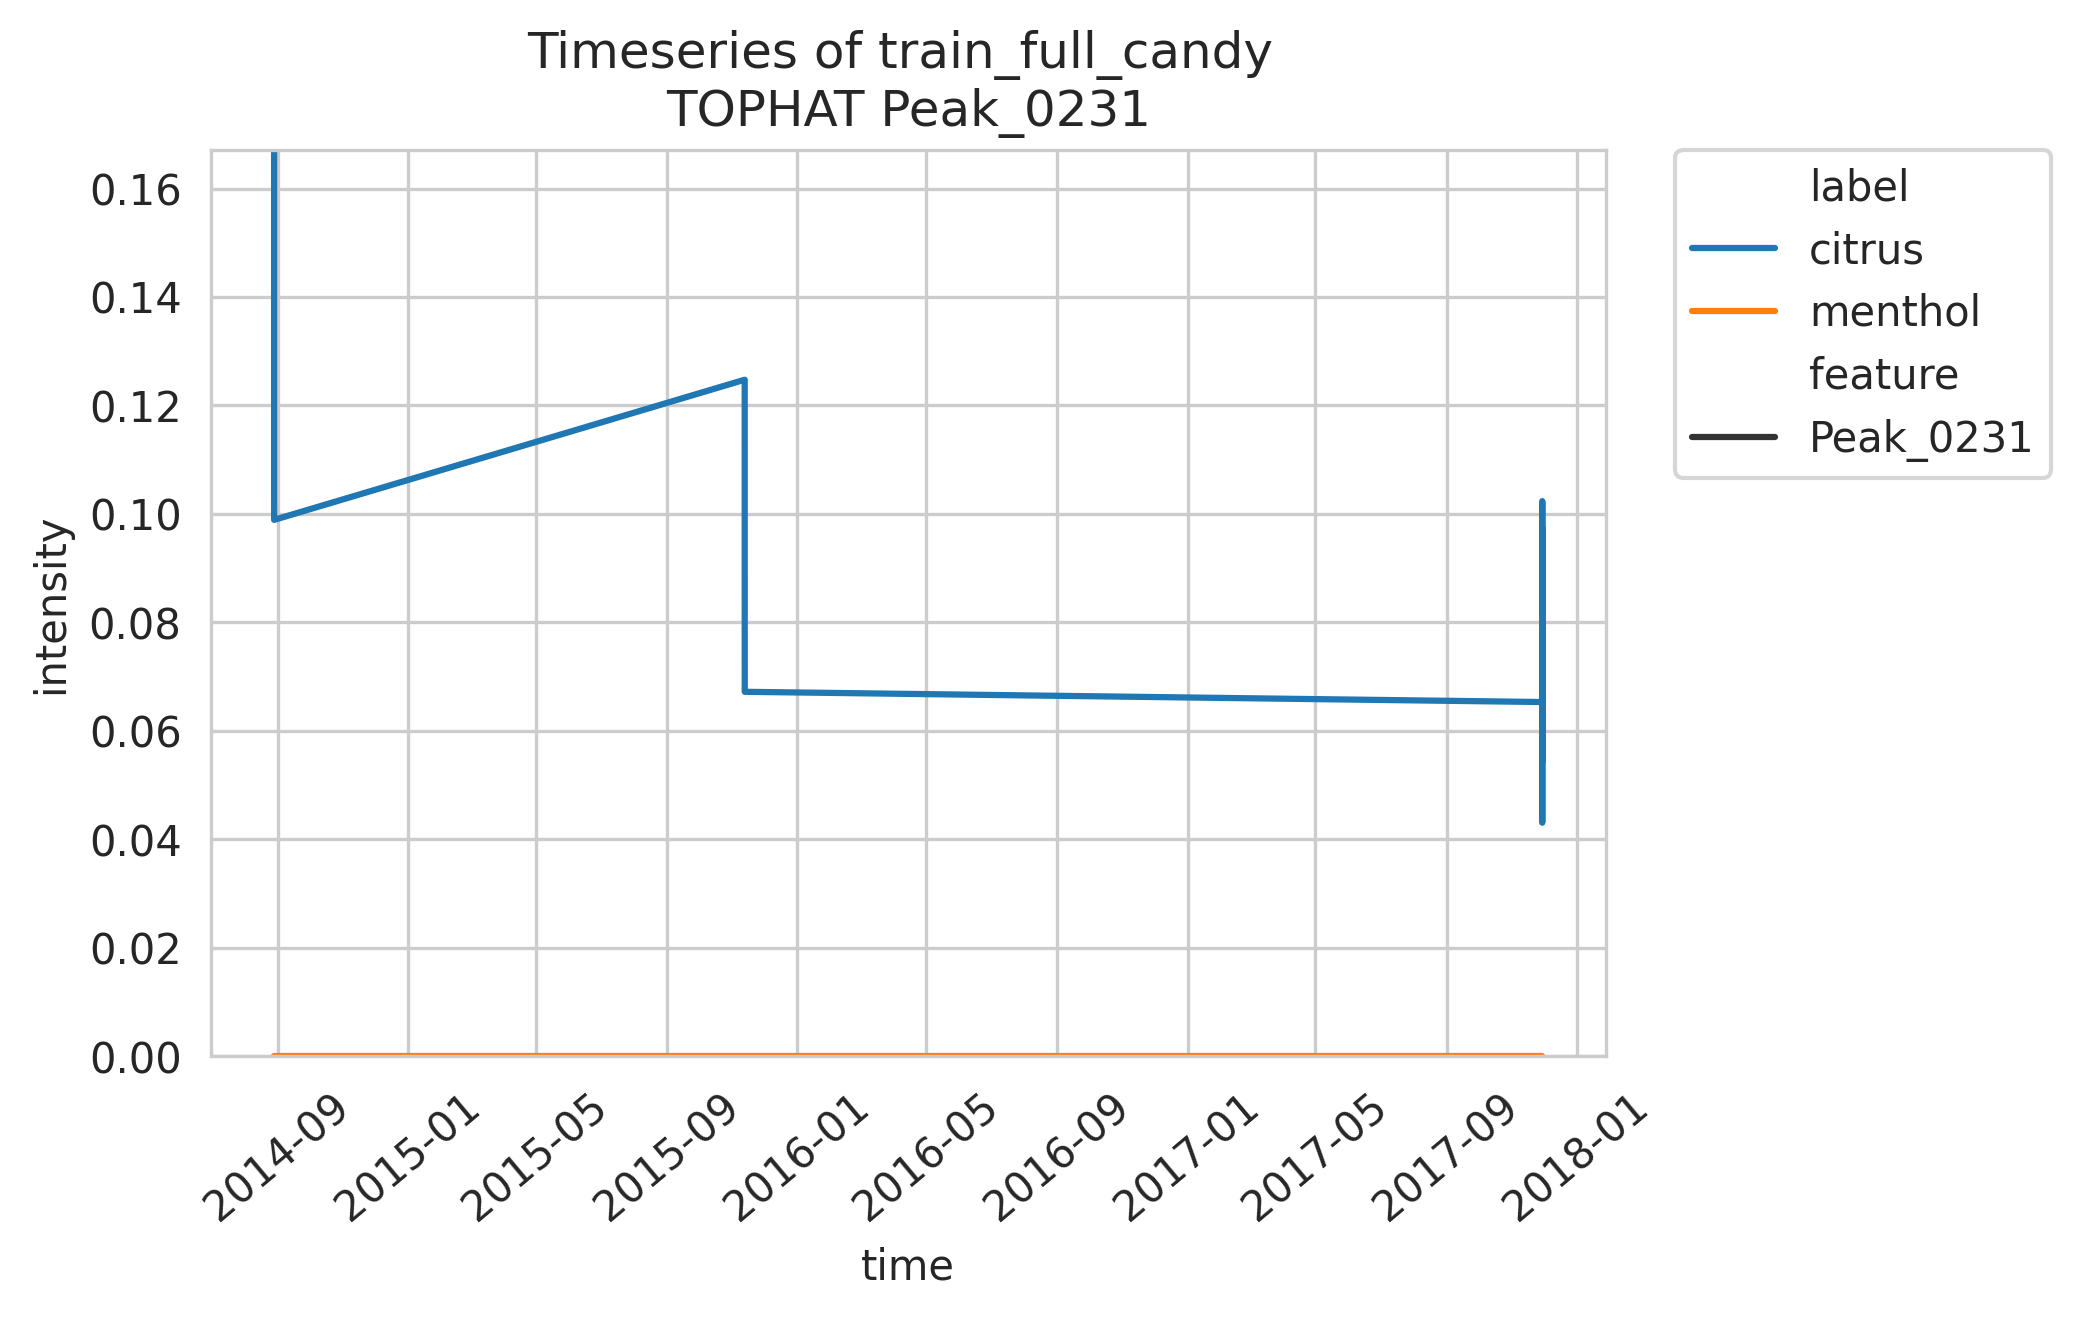

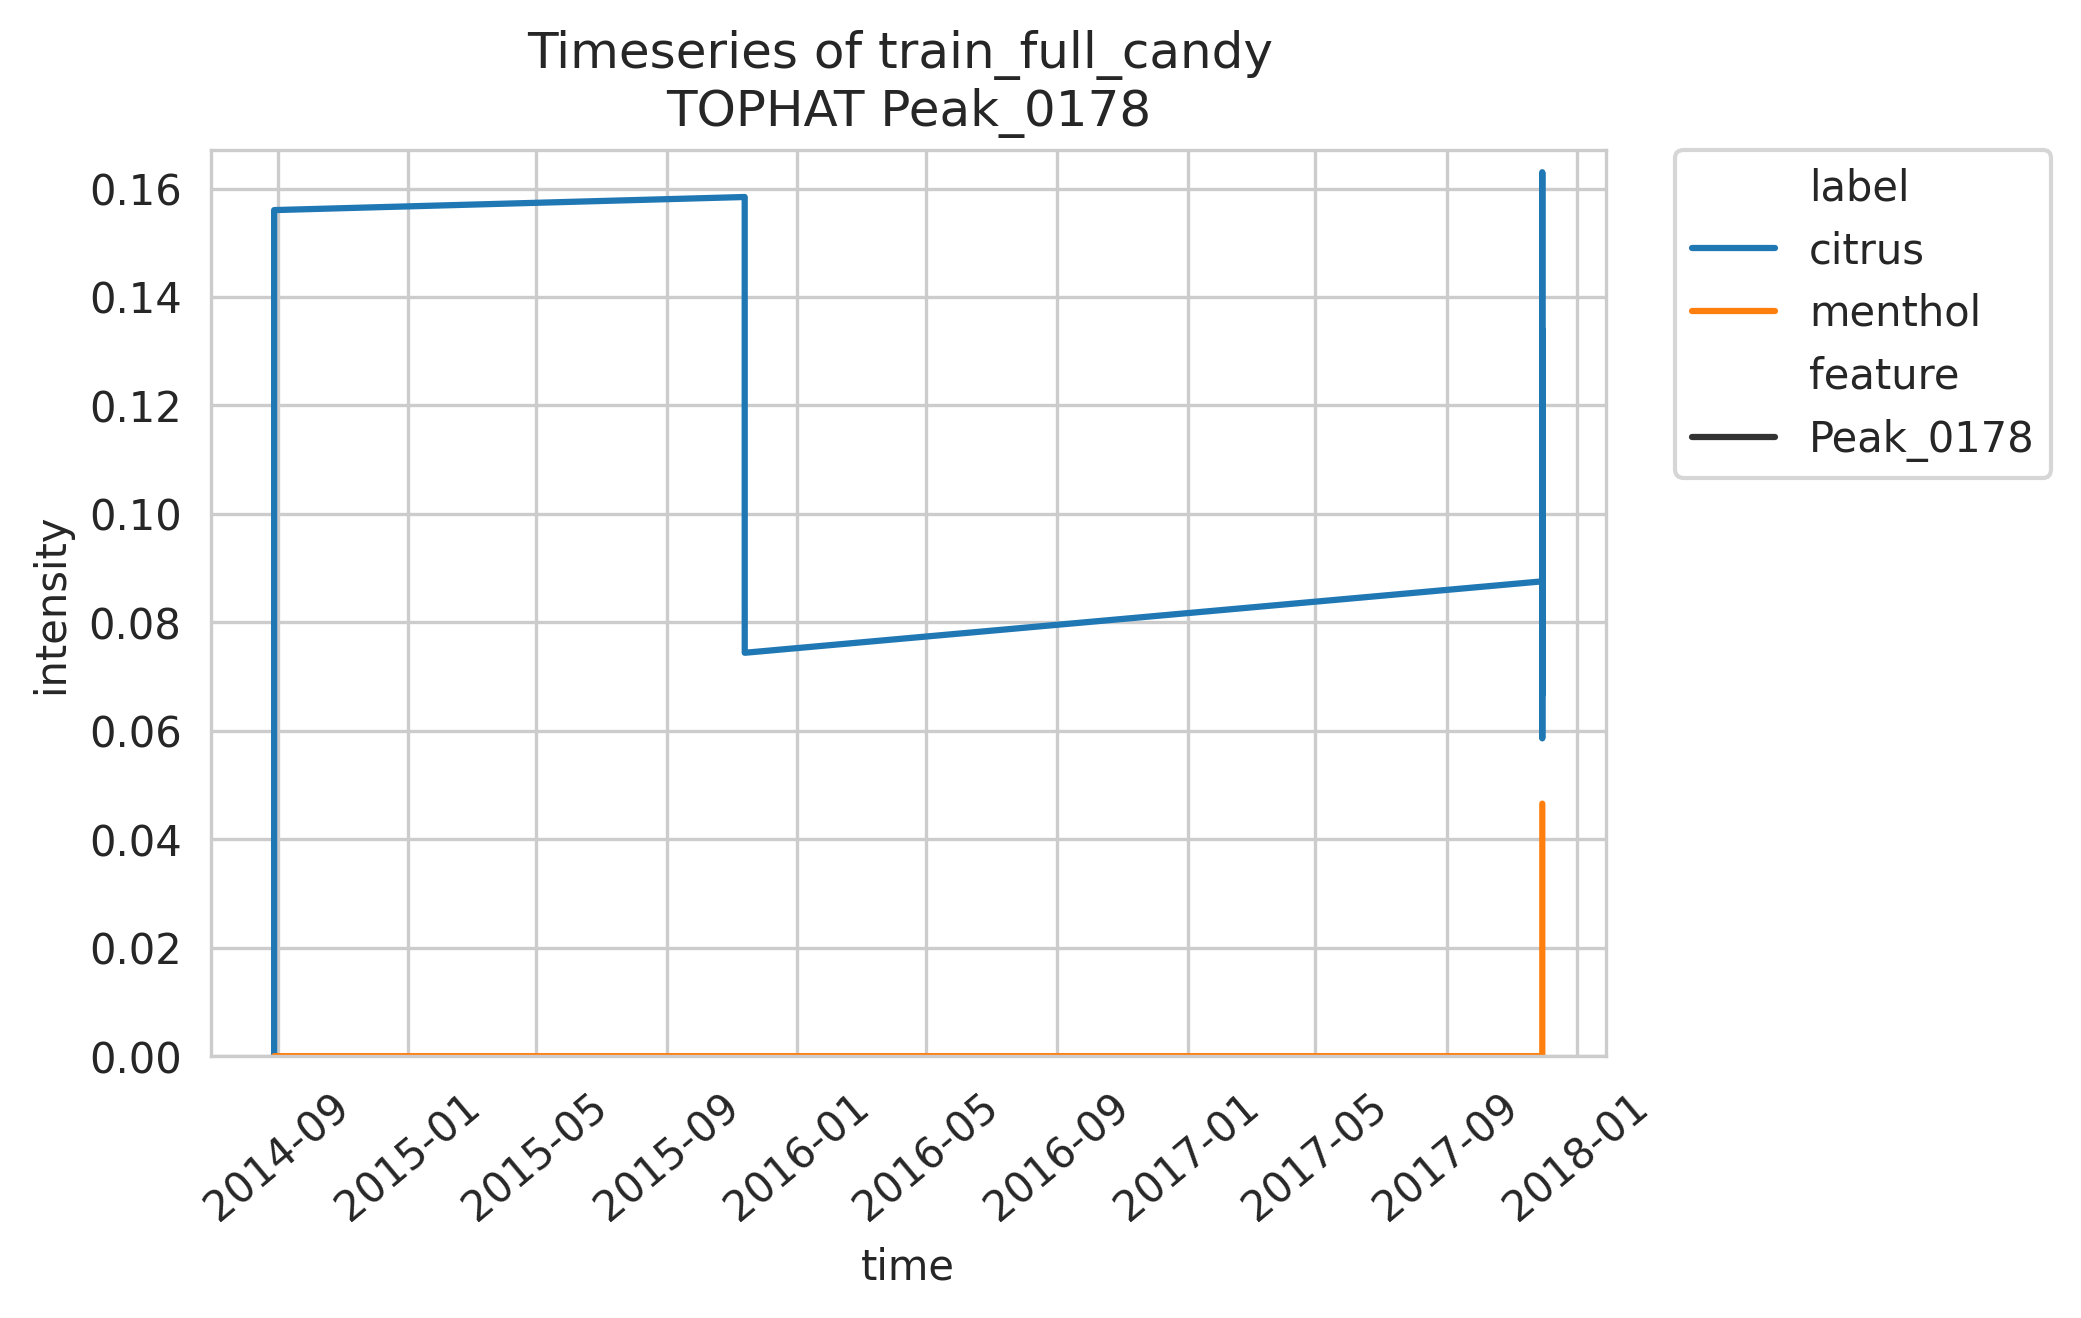

In [12]:
roc_plots = RocCurvePlot.ROCCurve(ims_analysis.analysis_result, plot_parameters=plot_parameters)
box_plots = BoxPlot.BoxPlotBestFeature(ims_analysis.analysis_result, plot_parameters=plot_parameters)

try:
    dt_plots = TreePlot.DecisionTrees(ims_analysis.analysis_result, plot_parameters=plot_parameters, limit_to_peak_detection_method_name="TOPHAT")
except FileNotFoundError as e:
    # might not both be installe - need system executable and python library
    print("Probably graphviz is not installed - install via `conda install graphviz python-graphviz`")
    raise(e)

ts_plots = TimeSeriesPlot.TimeSeriesFromAnalysis(ims_analysis, plot_parameters=plot_parameters, limit_to_pdmn=['TOPHAT'], limit_to_features=['Peak_0178','Peak_0231'])

roc_fn = roc_plots[2][-1]
box_plot_fn = box_plots[0][-1]
if dt_plots:
    dt_fn = Path(dt_plots[1][-1][-1])

ts_fn0 = ts_plots[1][0]
ts_fn1 = ts_plots[1][1]
    
# display images for the TOPHAT method
images = [roc_fn, box_plot_fn, dt_fn, ts_fn0, ts_fn1]

for fn in images:
    display(Image(fn))

In [13]:
# prediction - will use parameters and features from previous steps
predictionModel = PredictionModel(ims_analysis)

#  preparation - replace train_ with test_
#  otherwise can't find measurements - as the class labels don't match the measurement names
file_parameters['folder_path'] = file_parameters['folder_path'].replace("train_", "test_")
test_dir = file_parameters['folder_path']

test_result_dir = file_parameters['out_dir'].replace("train_", "test_")

test_measurements_fns = sorted(Path(test_dir).glob("*ims.csv"))
test_measurements = [MccImsMeasurement(fn) for fn in test_measurements_fns]

Parsing Measurement data/test_full_candy/BD18_1408280826_ims.csv
Parsing Measurement data/test_full_candy/BD18_1408280841_ims.csv
Parsing Measurement data/test_full_candy/BD18_1511121702_ims.csv
Parsing Measurement data/test_full_candy/BD18_1511121712_ims.csv
Parsing Measurement data/test_full_candy/BD18_1511121716_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291649_m2_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291659_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291702_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291705_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291719_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291743_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291746_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291753_ims.csv
Parsing Measurement data/test_full_candy/BD18_1711291800_ims.csv


In [14]:
# predict - and run full preprocessing and alignment on test_measurements
prediction = predictionModel.predict(test_measurements)

Applying External Preprocessing with ExternalPeakDetectionMethod.PEAX
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.SAVITZKY_GOLAY_FILTER
Applying denoising Method DenoisingMethod.MEDIAN_FILTER
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.SAVITZKY_GOLAY_FILTER
Applying denoising Method DenoisingMethod.MEDIAN_FILTER
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying Normalization

In [15]:
test_labels_dict_fn = MccImsAnalysis.guess_class_label_extension(test_dir)
test_labels_dict = MccImsAnalysis.parse_class_labels(test_labels_dict_fn)
class_labels = np.unique([m.class_label for m in ims_analysis.measurements])
test_measurements_names = [path.name for path in test_measurements_fns]
for pdm, prediction_index in prediction.items():
    predicted_labels = {test_name: class_labels[p] for p, test_name in zip(prediction_index, test_measurements_names)}
    correct = dict()
    false = dict()
    for fn, predicted_label in predicted_labels.items():
        if predicted_label == test_labels_dict[fn]:
            correct[fn] = predicted_label
        else:
            false[fn] = predicted_label

    print(f"resulting_labels for {pdm.name} are: {predicted_labels}")
    print(f"Falsely classified: {false}\n")
    print(f"That's {len(correct.keys())} correct vs {len(false.keys())} false\n")

resulting_labels for WATERSHED are: {'BD18_1408280826_ims.csv': 'menthol', 'BD18_1408280841_ims.csv': 'menthol', 'BD18_1511121702_ims.csv': 'citrus', 'BD18_1511121712_ims.csv': 'citrus', 'BD18_1511121716_ims.csv': 'menthol', 'BD18_1711291649_m2_ims.csv': 'citrus', 'BD18_1711291659_ims.csv': 'menthol', 'BD18_1711291702_ims.csv': 'menthol', 'BD18_1711291705_ims.csv': 'citrus', 'BD18_1711291719_ims.csv': 'citrus', 'BD18_1711291743_ims.csv': 'citrus', 'BD18_1711291746_ims.csv': 'menthol', 'BD18_1711291753_ims.csv': 'menthol', 'BD18_1711291800_ims.csv': 'menthol'}
Falsely classified: {'BD18_1511121716_ims.csv': 'menthol'}

That's 13 correct vs 1 false

resulting_labels for VISUALNOWLAYER are: {'BD18_1408280826_ims.csv': 'menthol', 'BD18_1408280841_ims.csv': 'menthol', 'BD18_1511121702_ims.csv': 'citrus', 'BD18_1511121712_ims.csv': 'citrus', 'BD18_1511121716_ims.csv': 'citrus', 'BD18_1711291649_m2_ims.csv': 'citrus', 'BD18_1711291659_ims.csv': 'menthol', 'BD18_1711291702_ims.csv': 'menthol',